In [1]:
from langchain_groq import ChatGroq
import os 
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(
    temperature=0,
    groq_api_key = os.environ['GROQ_KEY'],
    model_name="llama-3.3-70b-versatile"
)

# result = llm.invoke("What is Langgraph?")
# print(result.content)

In [9]:
from pydantic import BaseModel, Field
from typing import List
from typing_extensions import TypedDict

class Examiner(BaseModel):
    name: str = Field(
        description="Name of the examiner."
    )
    subject: str = Field(
        description="Subject that the examiner teaches.",
    )
    # description: str = Field(
    #     description="Description of the examiner focus, concerns, and motives.",
    # )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nSubject: {self.subject}\n"

class Perspectives(BaseModel):
    examiners: List[Examiner] = Field(
        description="Comprehensive list of examiners along with their subjects.",
    )

class GenerateExaminersState(TypedDict):
    grade: str # Grade that examiner teaches
    max_examiners: int # Number of examiners
    human_feedback: str # Human feedback
    examiners: List[Examiner] # Analyst asking questions

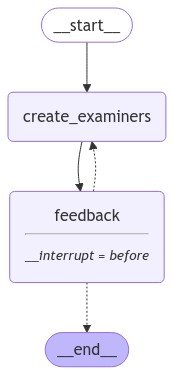

In [10]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

examiner_instructions="""You are tasked with creating a set of AI examiner personas. Follow these instructions carefully:

1. First, get the grade that the examiner teaches:
{grade}
        
2. Examine any feedback given to guide the creation of examiners: 
        
{human_feedback}
    
3. Determine the subjects that the examiner teaches based on the subjects appropriate for the grade or based on feedback.
                    
4. Pick the top {max_examiners} themes.

5. Assign one examiner to each theme."""

def create_examiners(state: GenerateExaminersState):
    
    
    grade=state['grade']
    max_examiners=state['max_examiners']
    human_feedback=state.get('human_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = examiner_instructions.format(grade=grade,
                                                  human_feedback=human_feedback, 
                                                  max_examiners=max_examiners)

    # Generate question 
    examiners = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of examiners.")])
    
    # Write the list of analysis to state
    return {"examiners": examiners.examiners}

def feedback(state: GenerateExaminersState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateExaminersState):
    """ Return the next node to execute """

    # Check if human feedback
    human_feedback=state.get('human_feedback', None)
    if human_feedback:
        return "create_examiners"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(GenerateExaminersState)
builder.add_node("create_examiners", create_examiners)
builder.add_node("feedback", feedback)
builder.add_edge(START, "create_examiners")
builder.add_edge("create_examiners", "feedback")
builder.add_conditional_edges("feedback", should_continue, ["create_examiners", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [11]:
grade = "8th"
max_examiners = 4
thread = {"configurable": {"thread_id": "1"}}

for event in graph.stream({"grade":grade,"max_examiners":max_examiners}, thread, stream_mode="values"):
    # Review
    examiners = event.get('examiners', '')
    if examiners:
        for examiner in examiners:
            print(f"Name: {examiner.name}")
            print(f"Role: {examiner.subject}")
            print("-" * 50)  

Name: Ms. Johnson
Role: Math
--------------------------------------------------
Name: Mr. Thompson
Role: Science
--------------------------------------------------
Name: Ms. Rodriguez
Role: English
--------------------------------------------------
Name: Mr. Lee
Role: History
--------------------------------------------------
